In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


c:\Users\admin\.pyenv\pyenv-win\versions\3.10.3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_id = 'microsoft/Florence-2-large'
model_id = "multimodalart/Florence-2-large-no-flash-attn"
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

c:\Users\admin\.pyenv\pyenv-win\versions\3.10.3\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `Pre

In [ ]:
import pandas as pd
import os
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

# Ваша функция run_example
def run_example(task_prompt, text_input=None, image=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].to(device),
      pixel_values=inputs["pixel_values"].to(device),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

def plot_bbox(image, data):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

def save_image_with_bbox(image, data, output_path):
    # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Save the plot
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

def crop_and_save_face(image, bbox, output_path):
    # Unpack the bounding box coordinates
    x1, y1, x2, y2 = bbox
    # Crop the image to the bounding box
    cropped_image = image.crop((x1, y1, x2, y2))
    # Save the cropped image
    cropped_image.save(output_path)

def process_csv(csv_path):
    print(f"Reading CSV file: {csv_path}")
    df = pd.read_csv(csv_path)
    for index, row in df.iterrows():
        link = row['link']
        imgs = eval(row['imgs'])
        animal_type = row['animal_type']
        status = row['status']
        id = link.split('/')[-1]

        # Skip if animal_type is 'Неизвестно'
        if animal_type.lower() == 'неизвестно':
            print(f"Skipping row {index} with unknown animal type.")
            continue

        # Create directory for this ad
        output_dir = f'imgs/{id}'
        os.makedirs(output_dir, exist_ok=True)

        for img_url in imgs:
            if img_url is None:
                print(f"Skipping image with None URL in row {index}.")
                continue
            if not img_url.startswith('http'):
                img_url = f'https://{img_url}'

            # Check if the image is already processed
            img_filename = img_url.split("/")[-1]
            img_path = os.path.join(output_dir, img_filename)
            if os.path.exists(img_path):
                print(f"Image {img_filename} already processed. Skipping.")
                continue

            try:
                print(f"Downloading image: {img_url}")
                image = Image.open(requests.get(img_url, stream=True).raw)
            except requests.exceptions.RequestException as e:
                print(f"Error downloading image {img_url}: {e}")
                continue

            task_prompt = '<OPEN_VOCABULARY_DETECTION>'
            if animal_type.lower() == 'кошка':
                text_input = "The face of a cat"
            elif animal_type.lower() == 'собака':
                text_input = "The face of a dog"
            else:
                print(f"Skipping row {index} with unsupported animal type: {animal_type}")
                continue  # Skip if animal_type is neither 'кошка' nor 'собака'

            print(f"Processing image: {img_filename}")
            results = run_example(task_prompt, text_input, image)
            bbox_results = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

            # Check if any face is detected
            if bbox_results['bboxes']:
                # Save the cropped image with the face
                print(f"Face detected. Saving cropped image: {img_path}")
                crop_and_save_face(image, bbox_results['bboxes'][0], img_path)
            else:
                print(f"No face detected in image: {img_filename}")

# Example usage
csv_path = 'links.csv'
process_csv(csv_path)


Reading CSV file: links.csv
Image 1731064093672df11dc31460.03673502_img_3989.webp already processed. Skipping.
Image 1731064091672df11b80cb97.68711406_img_4211.webp already processed. Skipping.
Image 1731064091672df11b985df5.24072615_img_4205.webp already processed. Skipping.
Image 1731064093672df11d529031.39392685_img_4390.webp already processed. Skipping.
Image 1731064093672df11dc31460.03673502_img_3989.webp already processed. Skipping.
Image 1731064091672df11b80cb97.68711406_img_4211.webp already processed. Skipping.
Image 1730919953672bbe11291ea0.55865793_1000030950.webp already processed. Skipping.
Image 1730919943672bbe07eea600.14049978_1000061093.webp already processed. Skipping.
Image 1730919945672bbe09284177.40888060_1000061087.webp already processed. Skipping.
Image 1730919946672bbe0a40eed4.80363815_1000061088.webp already processed. Skipping.
Image 1730919949672bbe0dc9add0.53721183_1000033106.webp already processed. Skipping.
Image 1730919953672bbe11291ea0.55865793_100003095

In [4]:
url = "https://cdn.pet911.ru/172801517166ff6b43627228.05094768_1000019671.webp"
image = Image.open(requests.get(url, stream=True).raw)

In [5]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].to(device),
      pixel_values=inputs["pixel_values"].to(device),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [6]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="The face of a cat")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[7.965000152587891, 236.10000610351562, 108.13500213623047, 336.9000244140625]], 'bboxes_labels': ['The face of a cat'], 'polygons': [], 'polygons_labels': []}}


In [7]:
def convert_to_od_format(data):
    """
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.

    Parameters:
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.

    Returns:
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.
    """
    # Extract bounding boxes and labels
    bboxes = data.get('bboxes', [])
    labels = data.get('bboxes_labels', [])

    # Construct the output format
    od_results = {
        'bboxes': bboxes,
        'labels': labels
    }

    return od_results

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

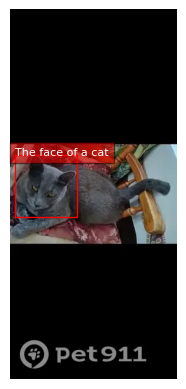

In [8]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

plot_bbox(image, bbox_results)